In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,random_split,Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [3]:
dataset = datasets.ImageFolder('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages', transform=transform)

In [5]:
images_ind = []
IGNORE_PATHS = [
    '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11702.jpg',
    '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/666.jpg'
]

for idx, (img_path, label) in enumerate(dataset.samples):
    if img_path not in IGNORE_PATHS:
        images_ind.append(idx)
        
new_dataset = Subset(dataset, indices=images_ind)

In [6]:
train_ratio = 0.7
test_ratio = 0.15
validation_ratio = 0.15
# Calculate the number of samples for each split
num_samples = len(new_dataset)
num_train = int(train_ratio * num_samples)
num_test = int(test_ratio * num_samples)
num_val = num_samples - num_train - num_test

# Use random_split to split the filtered dataset
train_data, test_validation_data = random_split(new_dataset, [num_train, num_test + num_val])
test_data, validation_data = random_split(test_validation_data, [num_test, num_val])

In [7]:
#Data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False)

In [9]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 14 * 14, 64)
        self.relu5 = nn.ReLU() 
        self.fc2 = nn.Linear(64, num_classes)
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu5(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
model = SimpleCNN().to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,weight_decay=0.001)

In [17]:
num_epochs = 15
loss_graph = []
loss_valid = []
accuracy_graph = []
accuracy_valid = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    # Print training loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    accuracy_train = correct_train / total_train * 100
    loss_graph.append(epoch_loss)
    accuracy_graph.append(accuracy_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy_train:.2f}%')
    # Validation loop
    model.eval()
    correct_val = 0
    total_val = 0
    test_loss = 0
    valid_loss = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    accuracy_val = correct_val / total_val * 100
    valid_loss = valid_loss / len(validation_loader)
    accuracy_valid.append(accuracy_val)
    loss_valid.append(valid_loss)
    print(f'validation Accuracy: {accuracy_val:.2f}% , validation loss : {valid_loss:.4f}')

Epoch 1/15, Loss: 0.6931, Accuracy: 50.21%
validation Accuracy: 49.05% , validation loss : 0.6932
Epoch 2/15, Loss: 0.6929, Accuracy: 50.24%
validation Accuracy: 49.05% , validation loss : 0.6930
Epoch 3/15, Loss: 0.6928, Accuracy: 50.40%
validation Accuracy: 49.05% , validation loss : 0.6930
Epoch 4/15, Loss: 0.6927, Accuracy: 50.27%
validation Accuracy: 49.67% , validation loss : 0.6928
Epoch 5/15, Loss: 0.6926, Accuracy: 51.69%
validation Accuracy: 49.43% , validation loss : 0.6928
Epoch 6/15, Loss: 0.6925, Accuracy: 51.34%
validation Accuracy: 50.04% , validation loss : 0.6927
Epoch 7/15, Loss: 0.6924, Accuracy: 51.66%
validation Accuracy: 49.91% , validation loss : 0.6926
Epoch 8/15, Loss: 0.6923, Accuracy: 51.72%
validation Accuracy: 51.21% , validation loss : 0.6925
Epoch 9/15, Loss: 0.6922, Accuracy: 52.61%
validation Accuracy: 52.71% , validation loss : 0.6923
Epoch 10/15, Loss: 0.6920, Accuracy: 52.93%
validation Accuracy: 55.00% , validation loss : 0.6921
Epoch 11/15, Loss: 

In [18]:
import matplotlib.pyplot as plt

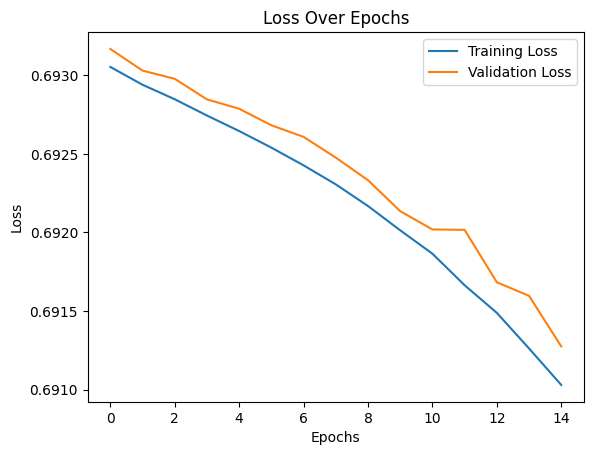

In [19]:
plt.plot(loss_graph, label='Training Loss')
plt.plot(loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

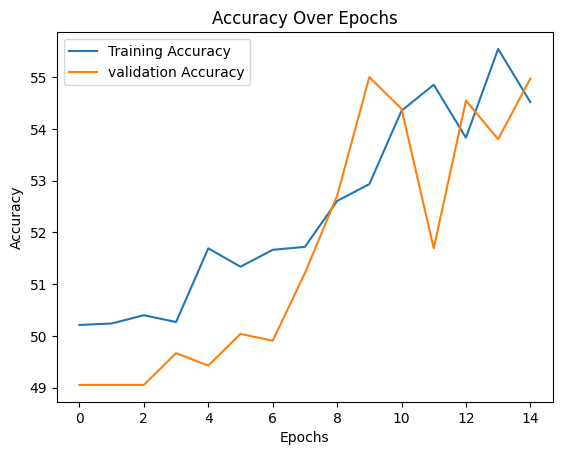

In [20]:
plt.plot(accuracy_graph, label='Training Accuracy')
plt.plot(accuracy_valid, label='validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Final Test Accuracy: 56.01%


Text(0.5, 1.0, 'Confusion Matrix')

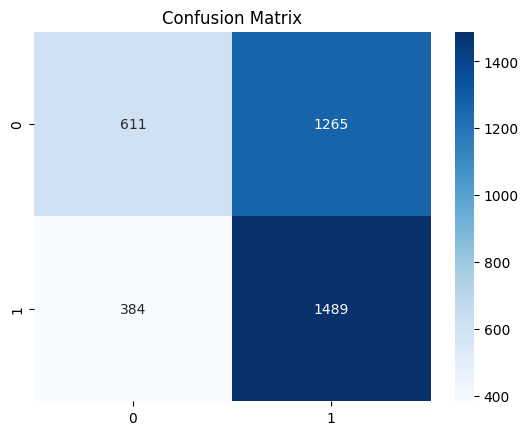

In [15]:
# Final evaluation on the test set
model.eval()
correct_top_test = 0
total_test = 0
all_labels = []
all_predictions_top = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        _, predicted_top = torch.max(outputs.data, 1)
        correct_top_test += (predicted_top == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions_top.extend(predicted_top.cpu().numpy())

        total_test += labels.size(0)

accuracy_test = correct_top_test / total_test * 100

print(f'Final Test Accuracy: {accuracy_test:.2f}%')

conf_matrix_top = confusion_matrix(all_labels, all_predictions_top)
sns.heatmap(conf_matrix_top, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")

In [97]:
import torch
import torch.nn as nn

# Define a function to create layers based on the YAML configuration
def create_layers(layer_configs):
    layers = []
    for layer_config in layer_configs:
        layer_type = layer_config['type']
        if layer_type == 'Conv2d':
            layers.append(nn.Conv2d(layer_config['in_channels'],
                                     layer_config['out_channels'],
                                     kernel_size=layer_config['kernel_size'],
                                     stride=layer_config['stride'],
                                     padding=layer_config['padding']))
        elif layer_type == 'MaxPool2d':
            layers.append(nn.MaxPool2d(kernel_size=layer_config['kernel_size'],
                                        stride=layer_config['stride']))
        elif layer_type == 'Flatten':
            layers.append(nn.Flatten())
        elif layer_type == 'Linear':
            layers.append(nn.Linear(layer_config['in_features'],
                                    layer_config['out_features']))
        elif layer_type == 'ReLU':
            layers.append(nn.ReLU())
        elif layer_type == 'Sigmoid':
            layers.append(nn.Sigmoid())
        else:
            raise ValueError(f"Invalid layer type: {layer_type}")
    return layers

# Load YAML configuration
with open('/kaggle/input/model1-cnn1/cnn1.yml', 'r') as file:
    config = yaml.safe_load(file)

# Extract model configuration and create layers
model_config = config['architecture']['model']
layer_configs = model_config['layers']
layers = create_layers(layer_configs)

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
# Instantiate the model
model = SimpleCNN(num_classes=config['hyperparameters']['num_classes']).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = getattr(optim, config['optimizer']['type'])(
    model.parameters(),
    lr=config['optimizer']['learning_rate'],
    weight_decay=config['optimizer']['weight_decay']
)

print(model)
print(criterion)
print(optimizer)

SimpleCNN(
  (layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=50176, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=2, bias=True)
  )
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)


In [98]:
# Training loop
hyperparameters = config['hyperparameters']
num_epochs = hyperparameters.get('num_epochs', 10)  # Default to 10 epochs if not specified
loss_graph = []
loss_valid = []
accuracy_graph = []
accuracy_valid = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)  # Move input data to device
        labels = labels.to(device)  # Move labels to device
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Print training loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    accuracy_train = correct_train / total_train * 100
    loss_graph.append(epoch_loss)
    accuracy_graph.append(accuracy_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy_train:.2f}%')

    # Validation loop
    model.eval()
    correct_val = 0
    total_val = 0
    test_loss = 0
    valid_loss = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)  # Move input data to device
            labels = labels.to(device)  # Move labels to device           
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    accuracy_val = correct_val / total_val * 100
    valid_loss = valid_loss / len(validation_loader)
    accuracy_valid.append(accuracy_val)
    loss_valid.append(valid_loss)
    print(f'Validation Accuracy: {accuracy_val:.2f}%, Validation Loss: {valid_loss:.4f}')


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/10, Loss: 0.6988, Accuracy: 52.94%
Validation Accuracy: 55.11%, Validation Loss: 0.6899
Epoch 2/10, Loss: 0.6882, Accuracy: 54.61%
Validation Accuracy: 53.16%, Validation Loss: 0.6902
Epoch 3/10, Loss: 0.6858, Accuracy: 56.29%
Validation Accuracy: 56.23%, Validation Loss: 0.6820
Epoch 4/10, Loss: 0.6852, Accuracy: 55.54%
Validation Accuracy: 57.26%, Validation Loss: 0.6789
Epoch 5/10, Loss: 0.6838, Accuracy: 55.85%
Validation Accuracy: 56.81%, Validation Loss: 0.6803
Epoch 6/10, Loss: 0.6826, Accuracy: 56.52%
Validation Accuracy: 57.16%, Validation Loss: 0.6794
Epoch 7/10, Loss: 0.6816, Accuracy: 56.73%
Validation Accuracy: 56.73%, Validation Loss: 0.6814
Epoch 8/10, Loss: 0.6804, Accuracy: 56.97%
Validation Accuracy: 57.90%, Validation Loss: 0.6784
Epoch 9/10, Loss: 0.6807, Accuracy: 56.90%
Validation Accuracy: 57.26%, Validation Loss: 0.6769
Epoch 10/10, Loss: 0.6805, Accuracy: 56.92%
Validation Accuracy: 57.58%, Validation Loss: 0.6776


In [99]:
model.eval()
correct_top_test = 0
total_test = 0
all_labels = []
all_predictions_top = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        _, predicted_top = torch.max(outputs.data, 1)
        correct_top_test += (predicted_top == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions_top.extend(predicted_top.cpu().numpy())

        total_test += labels.size(0)

accuracy_test = correct_top_test / total_test * 100

print(f'Final Test Accuracy: {accuracy_test:.2f}%')

Final Test Accuracy: 58.02%
